In [1]:
import time
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Here we are importing the h5 file and create a dataframe.

In [2]:
file = h5py.File('Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_energy_limit_0.01_deviation_0.1_lambda_um_0.8_points_100000_seed_6991.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)

# Here we specify the input and output variables

In [3]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [4]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

##### For now, we will work with a dataframe that only has Max Proton Energy as the output variable and name it df.

In [5]:
df = physics.copy()
df = df.drop(columns= outputs[1:])
df.columns

Index(['Intensity_(W_cm2)', 'Max_Proton_Energy_(MeV)', 'Pulse_Duration_(fs)',
       'Spot_Size_(FWHM um)', 'Target_Thickness (um)'],
      dtype='object')

##### The rows that contain negative Max Proton Energy will be dropped.

In [6]:
df = df[df[outputs[0]] > 0]

In [7]:
# df.to_csv('raw_data.csv', index=False)

##### The train and split sets will also be created here for df.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[[inputs[0], inputs[3]]], df[outputs[0]], test_size=0.90, random_state=0)

##### Normalizing the data

In [9]:
X_train_means = X_train.mean()
X_train_stds = X_train.std(ddof=1)
X_train_norm = (X_train - X_train_means) / X_train_stds

y_train_means = y_train.mean()
y_train_stds = y_train.std(ddof=1)
y_train_norm = (y_train - y_train_means) / y_train_stds

X_test_means = X_test.mean()
X_test_stds = X_test.std(ddof=1)
X_test_norm = (X_test - X_test_means) / X_test_stds

y_test_means = y_test.mean()
y_test_stds = y_test.std(ddof=1)
y_test_norm = (y_test - y_test_means) / y_test_stds

In [10]:
X_train_norm.head()

,Intensity_(W_cm2),Target_Thickness (um)
32779,-1.209431,1.671152
50591,0.306661,-0.762671
87578,1.060414,-0.081711
79365,-0.861870,-0.954956
42092,-1.081520,-0.084336


# Scatter plot of the data to be modeled.

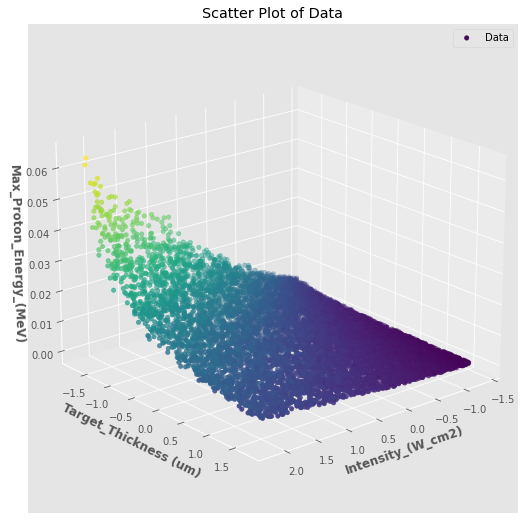

In [11]:
fig1 = plt.figure(figsize=(9, 9))
ax = fig1.add_subplot(projection='3d')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[3]],
           y_train,
           c = np.sqrt(y_train),
           label = "Data")
ax.set_title('Scatter Plot of Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
plt.show()

# Support Vector Regression model (SVR)

##### First we create a model to predict the values of the X test set to see what the predictions look like.

In [12]:
start_time = time.process_time()

In [13]:
svr_poly = SVR(kernel="poly", C=200, gamma="auto", degree=3, epsilon=0.0001, coef0=.3)
# svr_poly = LinearSVR(epsilon=0.45,
#                      tol=0.0001,
#                      C=1.0,
#                      loss='epsilon_insensitive',
#                      fit_intercept=True,
#                      intercept_scaling=1.0,
#                      dual=True,
#                      verbose=0,
#                      random_state=None,
#                      max_iter=5000
#                      )

In [14]:
svr_poly.fit(X_train_norm[[inputs[0], inputs[3]]], np.log(y_train))

SVR(C=200, coef0=0.3, epsilon=0.0001, gamma='auto', kernel='poly')

In [15]:
np.exp(svr_poly.predict(X_train_norm))

array([0.00051014, 0.00848085, 0.0079175 , ..., 0.00165338, 0.0180734 ,
       0.00552812])

##### CPU time to run, train, and predict data

In [16]:
end_time = time.process_time()
total_time = end_time - start_time
print(f'The CPU time for this model to run is {total_time} seconds.')

The CPU time for this model to run is 180.602206 seconds.


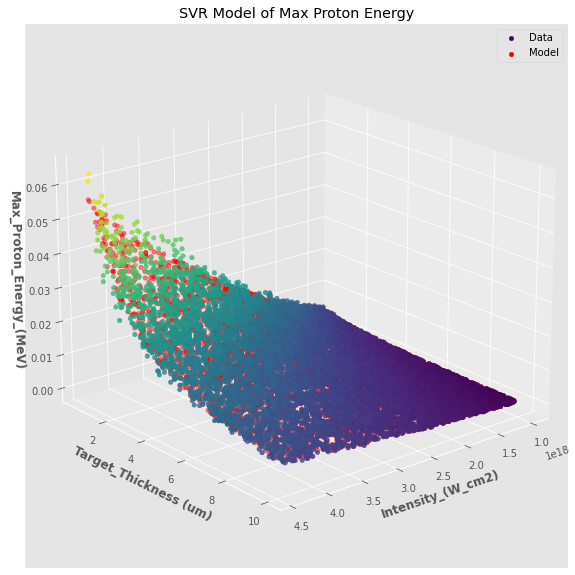

In [17]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           c = np.sqrt(y_train),
           alpha = .8,
           label= 'Data')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.exp(svr_poly.predict(X_train_norm)),
           c = 'red',
           alpha= .5,
           label= 'Model')
ax.set_title('SVR Model of Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
leg.legendHandles[0].set_alpha(1)
plt.show()

##### An error dataframe will be created for the log transformed data model for the testing sets. This dataframe will also contain the predicted values of the log model, and it will contain the predicted values of the model converted back into its original non log format.

In [18]:
error_3d = X_test_norm.copy()
error_3d['Predictions'] = np.exp(svr_poly.predict(X_test_norm))
error_3d[outputs[0]] = y_test
error_3d['Relative Error'] = np.abs((y_test - error_3d['Predictions']) / y_test) * 100

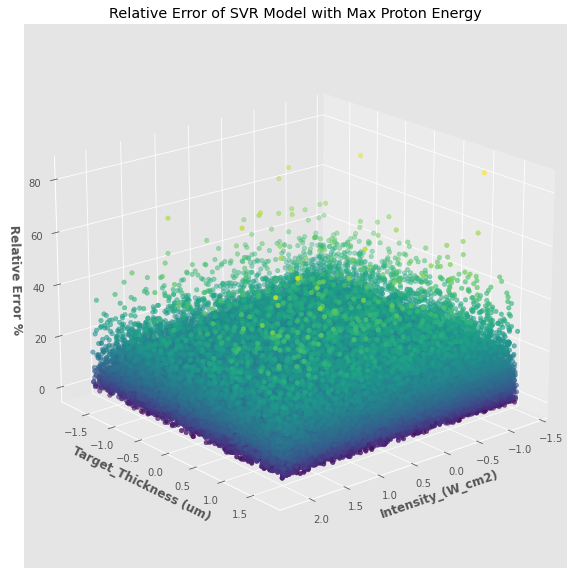

In [19]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_test_norm[inputs[0]],
           X_test_norm[inputs[3]],
           error_3d['Relative Error'],
           c = np.sqrt(error_3d['Relative Error']))
ax.set_title('Relative Error of SVR Model with Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

# Removing the mild and extreme outliers

In [20]:
error_3d_2 = error_3d.copy()
q1 = np.percentile(error_3d_2['Relative Error'], 25)
q3 = np.percentile(error_3d_2['Relative Error'], 75)
iqr = q3 - q1
error_3d_2 = error_3d_2[(error_3d_2['Relative Error'] >= q1 - 1.5 * iqr) & (error_3d_2['Relative Error'] <= q1 + 1.5 * iqr)]

In [21]:
error_3d_2

,Intensity_(W_cm2),Target_Thickness (um),Predictions,Max_Proton_Energy_(MeV),Relative Error
3582,0.973221,0.245240,0.006251,0.005764,8.442543
60498,1.973464,0.182823,0.010214,0.011291,9.539669
53227,-0.280373,0.355192,0.002606,0.002410,8.144050
21333,0.230799,0.894550,0.002924,0.003035,3.645928
3885,-1.324312,0.717939,0.000677,0.000614,10.150624
...,...,...,...,...,...
83919,1.144310,0.965178,0.004718,0.005449,13.417672
25039,-1.303922,-0.719751,0.001702,0.001912,10.966025
57802,-1.320893,-0.950045,0.002015,0.002264,11.016755
1230,0.636755,-0.654559,0.009488,0.008587,10.491536


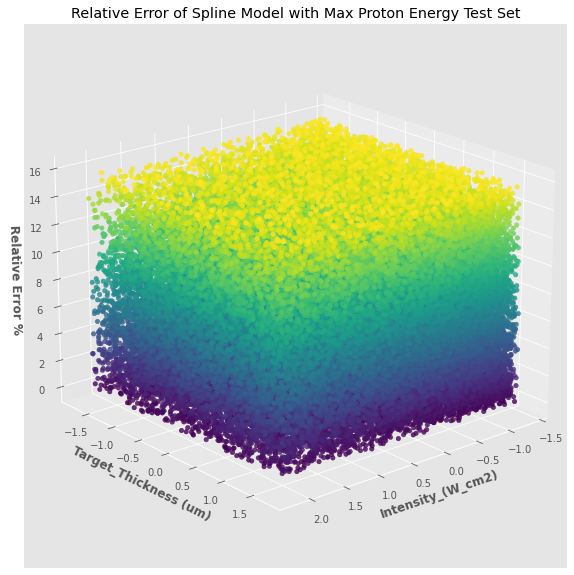

In [22]:
fig5 = plt.figure(figsize=(10, 10))
ax = fig5.add_subplot(projection='3d')
ax.scatter(error_3d_2[inputs[0]],
           error_3d_2[inputs[3]],
           error_3d_2['Relative Error'],
           alpha = .8,
           c = error_3d_2['Relative Error'])
ax.set_title('Relative Error of Spline Model with Max Proton Energy Test Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

# Summary

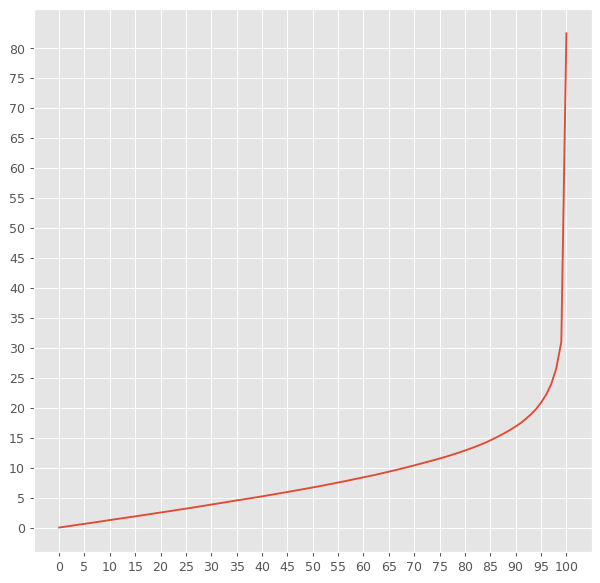

In [23]:
x = np.arange(0, 101, 1)
idk = np.zeros(101)

for i in range(len(idk)):
    idk[i] = np.percentile(error_3d['Relative Error'], x[i])


figure(figsize=(8, 8), dpi=90)
x_ticks = np.arange(0, 101, 5)
y_ticks = np.arange(0, np.max(error_3d['Relative Error']) +1, 5)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.plot(x, idk)
plt.show()

In [24]:
print(f'Size of testing set : {len(X_train)}\nSize of training set: {len(X_test)}')

Size of testing set : 10000
Size of training set: 90000


In [25]:
mean_squared_error(y_test, error_3d['Predictions'])

8.66303248625968e-07

In [26]:
print(f'Hours  : {total_time // 60**2}\nMinutes: {total_time // 60}\nSeconds: {np.abs(total_time - 60 * (total_time // 60 ))}')

Hours  : 0.0
Minutes: 3.0
Seconds: 0.6022059999999954


In [27]:
r2_score(y_test, error_3d['Predictions'])

0.982399820909451

In [28]:
np.percentile(error_3d['Relative Error'], 95)

20.84208822733981

# Optimizing the hyperparameters

In [29]:
# parameters = {'kernel': ('linear', 'poly', 'rbf'),
#               'C': [50, 100, 300],
#               'degree': [1, 2, 3],
#               'gamma': ('auto', 'scale'),
#               'epsilon': [.001, .01, .1],
#               'coef0': [.001, .1, .7]
#               }

In [30]:
# svr = SVR()

In [31]:
# clf = GridSearchCV(svr,
#                    parameters,
#                    n_jobs= -1,
#                    verbose= 2,
#                    cv = 3
#                    # )

In [32]:
# y_train_log = np.log(y_train)
# clf.fit(X_train_norm, y_train_log)